# Computer Vision (911.908)

## <font color='crimson'>Multilayer perceptrons (MLPs)</font>

**Changelog**:
- *Sep. 2020*: initial version (using PyTorch v1.6) 
- *Sep. 2021*: adaptations to PyTorch v1.9
- *Nov. 2022*: adaptations to PyTorch v1.13 + minor fixes
- *Oct. 2024*: adaptations to PyTorch v2.4

---

In this lecture, we will learn about a multi-layer extension of the simple Perceptron
model, aka **Multilayer Perceptrons (MLPs)** and also look at **activation functions**. 

Finally, we will briefly look at the **universal approximation theorem** for MLPs and some extensions.

---
## Content

- [Model](#Model)
- [Activation functions](#Activation-functions)
- [PyTorch building blocks for MLPs](#PyTorch-building-blocks-for-MLPs)
- [Universal approximation theorem](#Universal-approximation-theorem-(UAT))   

---
## Model

In the **perceptron model**, we directly mapped from inputs, $\mathbf{x} \in \mathbb{R}^d$, to $\{0,1\}$ via

$$ f(\mathbf{x},\mathbf{w}) = \phi (\langle \mathbf{x},\mathbf{w}\rangle)\enspace,
$$

where the bias is included in $\mathbf{w}$ and $\mathbf{x}$ is extended by a 1 at position 0. $\phi$ (activation) was the **indicator function** determining whether the input was $>0$ (in other words, a threshold at $0$).

However, we do not necessarily have to directly map from $\mathbb{R}^d$ to $\mathbb{R}$ and then apply a threshold as an activation function.

In general, we could have a mapping

$$ f: \mathbb{R}^d \to \mathbb{R}^e, \quad \mathbf{x} \mapsto \psi( \mathbf{W} \mathbf{x}+ \mathbf{b})$$

with a general activation function $\psi: \mathbb{R} \to \mathbb{R}$ which is applied elementwise to each element (i.e., to each coordinate of the output) of the output and $\mathbf{x} \in \mathbb{R}^{d}$, $\mathbf{W} \in \mathbb{R}^{e \times d}$, $\mathbf{b} \in \mathbb{R}^e$.
 
In fact, this concept can be used to build up a hierarchy of operations, e.g.:

$$\forall l \in \{1,\ldots,L\}: \mathbf{x}^{(l)} = 
\psi\left( \mathbf{W}^{(l)} \mathbf{x}^{(l-1)} + \mathbf{b}^{(l)}\right)
$$

where $\mathbf{x}^{(0)} = \mathbf{x}$ (input) and $\mathbf{x}^{(l-1)}$ denotes the output at **layer** $l-1$. Overall, we call this composition of functions a **multilayer perceptron (MLP)**, e.g., the output $\mathbf{x}^{(L)}$ at the $L$-th layer is given by

$$
f\left(\mathbf{x}, \{\mathbf{W}^{(l)}\}_{l=1}^L, \{\mathbf{b}^{(l)}\}_{l=1}^L\right) = \mathbf{x}^{(L)}
$$

Notably, if $\psi$ is linear, then $f$ is an affine function and we could implement this hierarchy simply by a **single** layer.

Adhering to the common terminology, we would call the original perceptron a *zero hidden layer* MLP. We will discuss an important property of a *one hidden layer MLP* later.

--- 

## Activation functions

Below are some common activation functions.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from torch.nn.functional import relu, sigmoid
import torch

**Hyperbolic tangent**

$$\tanh(z) = \frac{\sinh(z)}{\cosh(z)}$$

**Rectified Linear Unit (ReLU)**

$$\text{ReLU}(z) = \max\{0,z\}$$

**Sigmoid**

$$\text{sigm}(z) = \frac{1}{1+\exp(-z)}$$

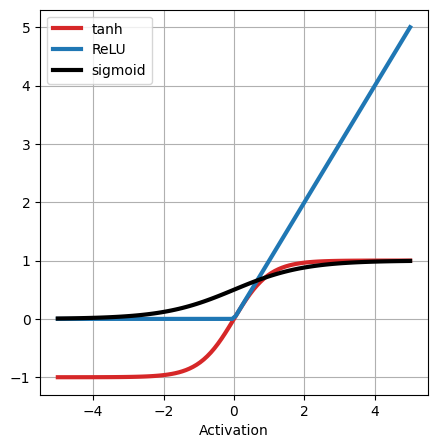

In [2]:
z = torch.linspace(-5,5,100)

plt.figure(figsize=(5,5))
plt.plot(z.numpy(), 
         torch.tanh(z).numpy(), 
         linewidth=3, color='tab:red', label='tanh')

plt.plot(z.numpy(), 
         torch.relu(z).numpy(), 
         linewidth=3, color='tab:blue', label='ReLU')

plt.plot(z.numpy(), 
         torch.sigmoid(z).numpy(), 
         linewidth=3, color='black', label='sigmoid')

plt.grid()
plt.xlabel('z');
plt.xlabel('Activation')
plt.legend();

---

## PyTorch building blocks for MLPs

PyTorch makes our life very easy to implement MLPs. In particular, we have affine maps (aka **linear** or **fully-connected** layers) available via `torch.nn.Linear`. 

We already have activation functions as well (either via, e.g., `nn.ReLU` or `torch.nn.functional.relu` in case of ReLU activations).

Via PyTorch's `torch.nn.Sequential` container, we can easily stack them together, by listing all the modules in the order that we want the input to be processed.

Hence, we can already build a simple two layer MLP, mapping from 10-dimensional input to 1-dimensional output.

In [3]:
import torch
import torch.nn as nn

In [4]:
lay0 = nn.Linear(10, 5, bias=False) # implements an affine map A_1x + b_1
act0 = nn.ReLU()
lay1 = nn.Linear(5, 1) # implements an affine map A_2x + b_2

# remark: you can disable the bias terms via bias=False
# e.g.,: lay0 = nn.Linear(10,5, bias=False) implements A_1x

mlp  = nn.Sequential(lay0, 
                     act0, 
                     lay1) 
# input
x = torch.rand(5,10)

# forward pass
out = mlp(x)
print(out.shape)

torch.Size([5, 1])


We'll see a more elegant (and actually the best-practice way) of doing this in a second.

---

## Universal approximation theorem (UAT)

The universal approximation theorem is very well stated on [Wikipedia](https://en.wikipedia.org/wiki/Universal_approximation_theorem).

Let $\psi: \mathbb{R} \to \mathbb{R}$ be a <font color='red'>nonconstant</font>, <font color='red'>bounded</font>, and <font color='red'>continuous</font> function. Let $I_m$ denote the $m$-dimensional unit hypercube $[0,1]^m$. The space of real-valued continuous functions on $I_m$ is denoted by $\mathcal{C}(I_m)$. Then, given any $\epsilon>0$ and any function $f \in \mathcal{C}(I_m)$, there <font color='red'>exists</font> an integer $N$, real constants $v_i,b_i \in \mathbb{R}$ and real vectors $\mathbf{w}_i \in \mathbb{R}^m$ for $i=1,\ldots,N$ such that we may define

$$
F(\mathbf{x}) = \sum_{i=1}^N v_i \psi(\mathbf{w}_i^\top \mathbf{x}+b_i)
$$

as an approximate realization of the function $f$, i.e., 

$$
\forall \mathbf{x} \in I_m : |F(\mathbf{x})-f(\mathbf{x})| < \epsilon
$$

Hence, functions of the form $F(\mathbf{x})$ are <font color='red'>dense</font> in 
$\mathcal{C}(I_m)$ and we can approximate $f$ to arbitrary accuracy ($\epsilon$). A first variant of this theorem was obtained by Cybenko (1989) and later extended by Hornik (1991).

**Remark**: The theorem is an *existence* statement and does not say anything about whether we can actually obtain such an approximation via optimization of a one hidden layer MLP.

**Extension 1**

The result also holds when replacing $I_m$ by any compact subset of $\mathbb{R}^m$.

**Extension 2**

You may have noticed the assumptions on $\psi$, i.e., nonconstant, bounded and continuous. Obviously, the most common activation function used in deep learning, e.g., the ReLU, is unbounded. Fortunately, Sonoda & Murata (2015) showed that the universal approximation property is also obtained with ReLU, see [here](https://arxiv.org/pdf/1505.03654.pdf).




### Experiment

Let's create some 1D toy data for $f(x) = \sin(x)$ first with $x \in [-2\pi,2\pi]$ (also adding some normally distributed noise).

In [5]:
import numpy as np
import math

function_to_learn = lambda x: np.sin(x) + \
    0.1*np.random.randn(*x.shape)

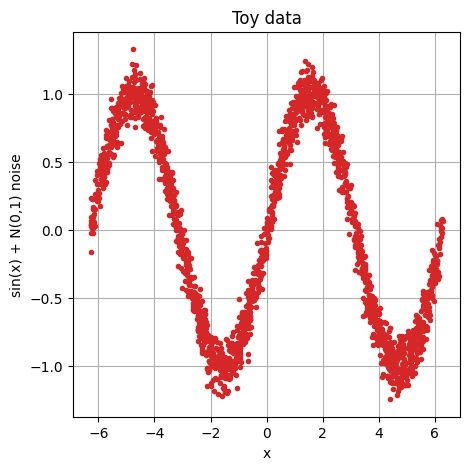

In [6]:
# Training
trn_x = np.float32(
    np.random.uniform(-2*math.pi, 
                      +2*math.pi, 
                      (1, 1000))).T
# Testing
tst_x = np.float32(
    np.random.uniform(-2*math.pi, 
                      +2*math.pi, 
                      (1, 1000))).T

all_x = np.concatenate((trn_x, tst_x),axis=0)

plt.figure(figsize=(5,5))
plt.plot(all_x, function_to_learn(all_x), '.', color='tab:red')
plt.xlabel('x')
plt.ylabel('sin(x) + N(0,1) noise')
plt.title('Toy data')
plt.grid();

Let's create our one hidden layer network, parametrized by the number of hidden units `H`. We'll have `D_in=1` and `D_out=1` in our experiment.

In [7]:
class Net(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Net, self).__init__()

        self.w1 = torch.nn.Linear(D_in, H)
        self.w2 = torch.nn.Linear(H, D_out)
    
    def forward(self, x):
        x = torch.relu(self.w1(x))
        x = self.w2(x)
        return x

Next, we instantiate the model.

In [8]:
H = 80
model = Net(1, H, 1) # the interesting parameter here is H

In [9]:
# Let's list the number of parametes

n_params = 0 
for p in model.parameters():
    n_params += p.numel() # numel = number of elements
print(n_params) 

241


Then, we (1) define our **loss** (to be discussed in detail later in the lecture) - which will be the mean-squared-error (MSE) - and (2) set the optimizer to Adam with a learning rate of $0.001$ (we will learn more about Adam and training details later). We train for $10,000$ epochs, i.e., $10,000$ runs over all our $1,000$ samples.

In [10]:
criterion = torch.nn.MSELoss(
    reduction='sum')
optimizer = torch.optim.Adam(
    model.parameters(), lr=1e-3)

x = torch.tensor(all_x, 
                 dtype=torch.float32)
y = torch.tensor(function_to_learn(all_x), 
                 dtype=torch.float32)

for t in range(50000):
    
    optimizer.zero_grad()

    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    
    if t % 1000 == 0:
        print('Epoch {:5d} | Loss: {:.2f}'.format(
            t, loss.item()))

Epoch     0 | Loss: 1428.46
Epoch  1000 | Loss: 66.26
Epoch  2000 | Loss: 23.03
Epoch  3000 | Loss: 20.91
Epoch  4000 | Loss: 20.60
Epoch  5000 | Loss: 20.35
Epoch  6000 | Loss: 20.24
Epoch  7000 | Loss: 20.16
Epoch  8000 | Loss: 20.07
Epoch  9000 | Loss: 19.97
Epoch 10000 | Loss: 19.94
Epoch 11000 | Loss: 19.91
Epoch 12000 | Loss: 19.88
Epoch 13000 | Loss: 19.86
Epoch 14000 | Loss: 19.83
Epoch 15000 | Loss: 19.80
Epoch 16000 | Loss: 19.78
Epoch 17000 | Loss: 19.77
Epoch 18000 | Loss: 19.76
Epoch 19000 | Loss: 19.77
Epoch 20000 | Loss: 19.75
Epoch 21000 | Loss: 19.76
Epoch 22000 | Loss: 19.81
Epoch 23000 | Loss: 19.75
Epoch 24000 | Loss: 19.77
Epoch 25000 | Loss: 19.77
Epoch 26000 | Loss: 19.77
Epoch 27000 | Loss: 19.74
Epoch 28000 | Loss: 19.81
Epoch 29000 | Loss: 19.76
Epoch 30000 | Loss: 19.74
Epoch 31000 | Loss: 19.76
Epoch 32000 | Loss: 19.80
Epoch 33000 | Loss: 19.77
Epoch 34000 | Loss: 19.75
Epoch 35000 | Loss: 19.74
Epoch 36000 | Loss: 19.88
Epoch 37000 | Loss: 19.76
Epoch 3800

Ok, let's evaluate our model on unseen data.

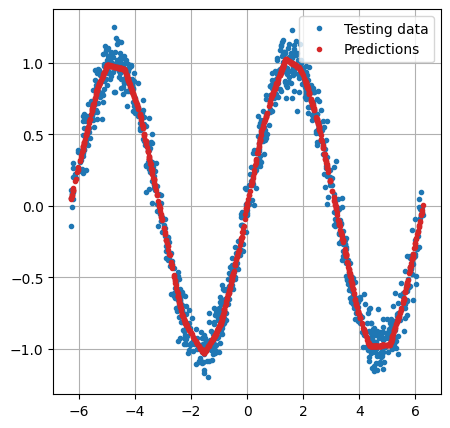

In [11]:
tst_x_tensor = torch.tensor(tst_x)

plt.figure(figsize=(5,5))
plt.plot(tst_x, 
         function_to_learn(tst_x),'.', color='tab:blue', 
         label='Testing data')
plt.plot(tst_x, 
         model(tst_x_tensor).detach().numpy(),'.', color='tab:red',
         label='Predictions')
plt.grid()
plt.legend();

**Not bad :)** As the UAT also does not state anything about the relation to the number of hidden units ($N$ in the theorem, `H` in our code), you generally need to experiment with this term to observe the effect (e.g., set `H` to 80).

# A simple MLP for MNIST digit images

In [12]:
class MNIST_Net(torch.nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        
        self.w1 = torch.nn.Linear(28*28, 100)
        self.w2 = torch.nn.Linear(100,    10)

    def forward(self, x):
        x = torch.relu(self.w1(x))
        x = self.w2(x)
        return x

In [13]:
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

ds = datasets.MNIST('./data', 
                    train=True, 
                    download=True, 
                    transform=transform)

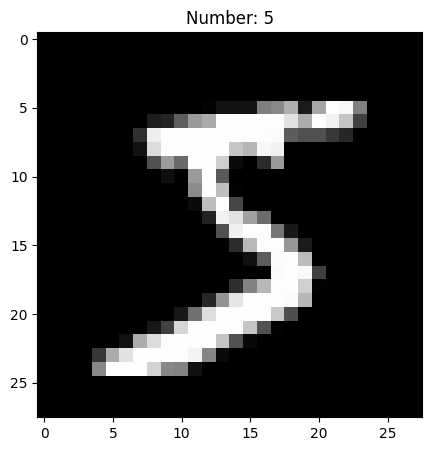

In [19]:
plt.figure(figsize=(5,5))
plt.imshow(ds[0][0].numpy()[0,:,:], cmap='gray');
plt.title('Number: {}'.format(ds[0][1]));

In [23]:
net = MNIST_Net()
img = ds[0][0]
print(img.size())

img_v = img.view(1,28*28)
print(img_v.size())

out = net(img_v)
print(out.size())

# now we would have to do something with this output which 
# we will learn in our lecture on loss functions.

torch.Size([1, 28, 28])
torch.Size([1, 784])
torch.Size([1, 10])


In [16]:
dl = torch.utils.data.DataLoader(ds, batch_size=64, shuffle=True)
batch = next(iter(dl))
out = net(batch[0].view(batch[0].size(0),-1))
print(out.size())

torch.Size([64, 10])


In [16]:
ds[0][0].shape

torch.Size([1, 28, 28])